In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-08-14 16:33:52 - ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache
2023-08-14 16:33:52 - src.ast_utils - DEBUG    - Using cache folder: /Users/guydavidson/tmp/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-14 16:33:54 - src.ast_utils - INFO     - Loading from cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-14 16:33:54 - src.ast_utils - INFO     - Finished loading cache file: /Users/guydavidson/tmp/game_generation_cache/interactive-beta-cache.pkl.gz


98 6272 64.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.969698,0.980189,0.972097,0.982683,0.983234,0.984843,0.941296,0.930606,0.994540,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.986488,0.985033,0.968718,0.980055,0.979109,0.985450,0.923794,0.930399,0.947819,0.953640
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.948358,0.973556,0.000000,0.000000,0.000000,0.000000,0.864027,0.869713,0.939114,0.951486
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.987400,0.980873,0.000000,0.000000,0.000000,0.000000,0.941296,0.930606,0.994540,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.985927,0.981736,0.000000,0.000000,0.000000,0.000000,0.978163,0.977679,0.974040,0.979537


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = 'full_features_no_in_data_all_2023_08_09'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



354


In [8]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [9]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -96.9309 ± 1.0502, min = -100.7051, max = -95.1030
20th percentile negative energy: -90.9552993774414


In [ ]:
data_df.groupby('real')[[c for c in data_df.columns if 'in_data' in c]].mean()

In [ ]:
data_df.groupby('real')[[c for c in data_df.columns if 'starts_and_ends_once' in c]].describe()

## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.1137, std: 2.7242, bias: 0.0100


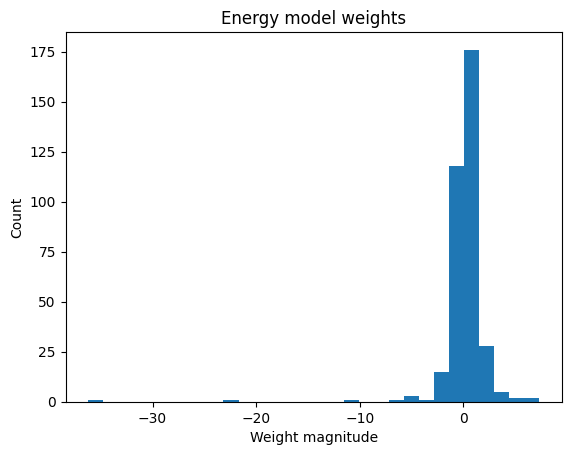

In [10]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [11]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (38, 10.73%) of the weights have magnitude < 0.0652
Approximately 25.0% (89, 25.14%) of the weights have magnitude < 0.2100
Approximately 50.0% (179, 50.56%) of the weights have magnitude < 0.5287
Approximately 75.0% (266, 75.14%) of the weights have magnitude < 1.0647
Approximately 90.0% (319, 90.11%) of the weights have magnitude < 2.1729
Approximately 95.0% (337, 95.20%) of the weights have magnitude < 2.9334
Approximately 99.0% (351, 99.15%) of the weights have magnitude < 7.3081


## Print the top K features most and least predictive of real games

In [12]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_5_score (-36.2073)
2. ast_ngram_constraints_n_5_score (-23.0812)
3. ast_ngram_setup_n_5_score (-10.9404)
4. ast_ngram_scoring_n_5_score (-6.6049)
5. variables_used_all (-5.4707)
6. predicate_found_in_data_constraints_prop (-5.0668)
7. preferences_used_all (-4.8858)
8. ast_ngram_terminal_n_5_score (-3.6774)
9. max_depth_setup_0 (-2.4723)
10. node_count_setup_0 (-2.4709)
11. section_doesnt_exist_setup (-2.4644)
12. mean_depth_setup_0 (-2.3912)
13. in_motion_arg_types_small_objects_constraints (-2.3220)
14. mean_depth_constraints_4 (-2.0354)
15. pref_forall_pref_forall_correct_arity_correct (-1.9362)
16. on_arg_types_furniture_large_objects_constraints (-1.9153)
17. variables_defined_all (-1.8872)
18. setup_objects_used (-1.8641)
19. on_arg_types_furniture_any_object_constraints (-1.8270)
20. in_arg_types_receptacles_any_object_constraints (-1.7976)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (7.3072)
2. pref_forall_used_incorrect (6.4336)
3. repeated_variables_found (5.0172)
4. two_number_operation_found (4.5914)
5. disjoint_seq_funcs_found (4.3275)
6. in_arg_types_other_constraints (3.9242)
7. redundant_expression_found (3.8076)
8. pref_forall_pref_forall_correct_arity_incorrect (3.4089)
9. adjacent_arg_types_other_constraints (3.0110)
10. in_motion_arg_types_agent_constraints (2.9301)
11. in_motion_arg_types_other_setup (2.8915)
12. disjoint_at_end_found (2.8633)
13. agent_holds_arg_types_other_setup (2.8551)
14. in_motion_arg_types_room_features_constraints (2.8210)
15. nested_logicals_found (2.7559)
16. agent_holds_arg_types_room_features_constraints (2.6763)
17. agent_holds_arg_types_agent_constraints (2.5585)
18. in_motion_arg_types_other_constraints (2.4865)
19. agent_holds_arg_types_other_constraints (2.4104)
20. agent_holds_arg_types_furniture_constraints (2.3928)

In [29]:
GRAMMAR_CONTEXT_FEATURES = [
    'variables_defined_all',
    'variables_defined_incorrect_count',
    'variables_used_all',
    'variables_used_incorrect_count',
    'preferences_used_all',
    'preferences_used_incorrect_count',

    'repeated_variables_found',
    'repeated_variable_type_in_either',

    'section_without_pref_or_total_count_terminal',
    'section_without_pref_or_total_count_scoring',
    'section_doesnt_exist_setup',
    'section_doesnt_exist_terminal',
]

NGRAM_AND_DATA_BASED_FEATURES = [
    'predicate_found_in_data_setup_prop',
    'predicate_found_in_data_constraints_prop',
    'ast_ngram_full_n_5_score',
    'ast_ngram_setup_n_5_score',
    'ast_ngram_constraints_n_5_score',
    'ast_ngram_terminal_n_5_score',
    'ast_ngram_scoring_n_5_score'
]

COUNTING_FEATURES = [
    # How many preferences are defined
    'num_preferences_defined_1',
    'num_preferences_defined_2',
    'num_preferences_defined_3',
    'num_preferences_defined_4',
    'num_preferences_defined_5',
    'num_preferences_defined_6',
    # How many modals are under a then
    'length_of_then_modals_1',
    'length_of_then_modals_2',
    'length_of_then_modals_3',
    'length_of_then_modals_4',
    'length_of_then_modals_5',
    'length_of_then_modals_6',
    'length_of_then_modals_7',
    # Various features related to variable quantifications
    'max_quantification_count_setup_0',
    'max_quantification_count_setup_1',
    'max_quantification_count_setup_2',
    'max_quantification_count_setup_3',
    'max_quantification_count_setup_4',
    'max_quantification_count_setup_5',
    'max_quantification_count_constraints_0',
    'max_quantification_count_constraints_1',
    'max_quantification_count_constraints_2',
    'max_quantification_count_constraints_3',
    'max_quantification_count_constraints_4',
    'max_quantification_count_constraints_5',
    'max_number_variables_types_quantified_types_1',
    'max_number_variables_types_quantified_types_2',
    'max_number_variables_types_quantified_types_3',
    'max_number_variables_types_quantified_types_4',
    'max_number_variables_types_quantified_types_5',
    'max_number_variables_types_quantified_types_6',
    'max_number_variables_types_quantified_types_7',
    'max_number_variables_types_quantified_types_8',
    'max_number_variables_types_quantified_variables_1',
    'max_number_variables_types_quantified_variables_2',
    'max_number_variables_types_quantified_variables_3',
    'max_number_variables_types_quantified_variables_4',
    'max_number_variables_types_quantified_variables_5',
    'max_number_variables_types_quantified_variables_6',
    'max_number_variables_types_quantified_variables_7',
    'max_number_variables_types_quantified_variables_8',
    # Man and max depth and node count
    'max_depth_setup_0',
    'max_depth_setup_1',
    'max_depth_setup_2',
    'max_depth_setup_3',
    'max_depth_setup_4',
    'max_depth_constraints_0',
    'max_depth_constraints_1',
    'max_depth_constraints_2',
    'max_depth_constraints_3',
    'max_depth_constraints_4',
    'max_depth_terminal_0',
    'max_depth_terminal_1',
    'max_depth_terminal_2',
    'max_depth_terminal_3',
    'max_depth_terminal_4',
    'max_depth_scoring_0',
    'max_depth_scoring_1',
    'max_depth_scoring_2',
    'max_depth_scoring_3',
    'max_depth_scoring_4',
    'mean_depth_setup_0',
    'mean_depth_setup_1',
    'mean_depth_setup_2',
    'mean_depth_setup_3',
    'mean_depth_setup_4',
    'mean_depth_constraints_0',
    'mean_depth_constraints_1',
    'mean_depth_constraints_2',
    'mean_depth_constraints_3',
    'mean_depth_constraints_4',
    'mean_depth_terminal_0',
    'mean_depth_terminal_1',
    'mean_depth_terminal_2',
    'mean_depth_terminal_3',
    'mean_depth_terminal_4',
    'mean_depth_scoring_0',
    'mean_depth_scoring_1',
    'mean_depth_scoring_2',
    'mean_depth_scoring_3',
    'mean_depth_scoring_4',
    'node_count_setup_0',
    'node_count_setup_1',
    'node_count_setup_2',
    'node_count_setup_3',
    'node_count_setup_4',
    'node_count_constraints_0',
    'node_count_constraints_1',
    'node_count_constraints_2',
    'node_count_constraints_3',
    'node_count_constraints_4',
    'node_count_terminal_0',
    'node_count_terminal_1',
    'node_count_terminal_2',
    'node_count_terminal_3',
    'node_count_terminal_4',
    'node_count_scoring_0',
    'node_count_scoring_1',
    'node_count_scoring_2',
    'node_count_scoring_3',
    'node_count_scoring_4',
]

FORALL_FEATURES = [
    'pref_forall_count_once_per_external_objects_used_correct',
    'pref_forall_count_once_per_external_objects_used_incorrect',
    'pref_forall_count_once_per_external_objects_used_incorrect_count',
    'pref_forall_external_forall_used_correct',
    'pref_forall_external_forall_used_incorrect',
    'pref_forall_external_forall_used_incorrect_count',
    'pref_forall_used_correct',
    'pref_forall_used_incorrect',
    'pref_forall_used_incorrect_count',
    'pref_forall_pref_forall_correct_arity_correct',
    'pref_forall_pref_forall_correct_arity_incorrect',
    'pref_forall_pref_forall_correct_arity_incorrect_count',
    'pref_forall_pref_forall_correct_types_correct',
    'pref_forall_pref_forall_correct_types_incorrect',
    'pref_forall_pref_forall_correct_types_incorrect_count',
]

PREDICATE_UNDER_MODAL_FEATURES = [
    'predicate_under_modal_once_measure_in_motion',
    'predicate_under_modal_once_measure_on',
    'predicate_under_modal_once_measure_between',
    'predicate_under_modal_once_measure_adjacent',
    'predicate_under_modal_once_measure_agent_holds',
    'predicate_under_modal_once_measure_adjacent_side_3',
    'predicate_under_modal_once_measure_object_orientation',
    'predicate_under_modal_once_measure_touch',
    'predicate_under_modal_once_measure_distance',
    'predicate_under_modal_once_measure_in',
    'predicate_under_modal_at_end_in_motion',
    'predicate_under_modal_at_end_on',
    'predicate_under_modal_at_end_between',
    'predicate_under_modal_at_end_adjacent',
    'predicate_under_modal_at_end_agent_holds',
    'predicate_under_modal_at_end_adjacent_side_3',
    'predicate_under_modal_at_end_object_orientation',
    'predicate_under_modal_at_end_touch',
    'predicate_under_modal_at_end_distance',
    'predicate_under_modal_at_end_in',
    'predicate_under_modal_once_in_motion',
    'predicate_under_modal_once_on',
    'predicate_under_modal_once_between',
    'predicate_under_modal_once_adjacent',
    'predicate_under_modal_once_agent_holds',
    'predicate_under_modal_once_adjacent_side_3',
    'predicate_under_modal_once_object_orientation',
    'predicate_under_modal_once_touch',
    'predicate_under_modal_once_distance',
    'predicate_under_modal_once_in',
    'predicate_under_modal_hold_in_motion',
    'predicate_under_modal_hold_on',
    'predicate_under_modal_hold_between',
    'predicate_under_modal_hold_adjacent',
    'predicate_under_modal_hold_agent_holds',
    'predicate_under_modal_hold_adjacent_side_3',
    'predicate_under_modal_hold_object_orientation',
    'predicate_under_modal_hold_touch',
    'predicate_under_modal_hold_distance',
    'predicate_under_modal_hold_in',
    'predicate_under_modal_while_hold_in_motion',
    'predicate_under_modal_while_hold_on',
    'predicate_under_modal_while_hold_between',
    'predicate_under_modal_while_hold_adjacent',
    'predicate_under_modal_while_hold_agent_holds',
    'predicate_under_modal_while_hold_adjacent_side_3',
    'predicate_under_modal_while_hold_object_orientation',
    'predicate_under_modal_while_hold_touch',
    'predicate_under_modal_while_hold_distance',
    'predicate_under_modal_while_hold_in',
]

PREDICATE_ROLE_FILLER_FEATURES = [
    'adjacent_arg_types_balls_furniture_setup',
    'adjacent_arg_types_blocks_furniture_setup',
    'adjacent_arg_types_blocks_room_features_setup',
    'adjacent_arg_types_furniture_large_objects_setup',
    'adjacent_arg_types_furniture_ramps_setup',
    'adjacent_arg_types_furniture_receptacles_setup',
    'adjacent_arg_types_other_setup',
    'adjacent_arg_types_receptacles_room_features_setup',
    'adjacent_arg_types_agent_balls_constraints',
    'adjacent_arg_types_agent_blocks_constraints',
    'adjacent_arg_types_agent_furniture_constraints',
    'adjacent_arg_types_agent_large_objects_constraints',
    'adjacent_arg_types_agent_ramps_constraints',
    'adjacent_arg_types_agent_receptacles_constraints',
    'adjacent_arg_types_agent_room_features_constraints',
    'adjacent_arg_types_other_constraints',
    'adjacent_arg_types_receptacles_room_features_constraints',
    'adjacent_arg_types_room_features_room_features_constraints',
    'adjacent_side_3_arg_types_furniture_sides_large_objects_setup',
    'adjacent_side_3_arg_types_other_setup',
    'adjacent_side_3_arg_types_receptacles_sides_blocks_setup',
    'adjacent_side_3_arg_types_other_constraints',
    'agent_holds_arg_types_other_setup',
    'agent_holds_arg_types_agent_constraints',
    'agent_holds_arg_types_any_object_constraints',
    'agent_holds_arg_types_balls_constraints',
    'agent_holds_arg_types_blocks_constraints',
    'agent_holds_arg_types_furniture_constraints',
    'agent_holds_arg_types_large_objects_constraints',
    'agent_holds_arg_types_other_constraints',
    'agent_holds_arg_types_receptacles_constraints',
    'agent_holds_arg_types_room_features_constraints',
    'agent_holds_arg_types_small_objects_constraints',
    'between_arg_types_other_setup',
    'between_arg_types_other_constraints',
    'distance_arg_types_balls_furniture_setup',
    'distance_arg_types_balls_receptacles_setup',
    'distance_arg_types_balls_room_features_setup',
    'distance_arg_types_blocks_blocks_setup',
    'distance_arg_types_blocks_furniture_setup',
    'distance_arg_types_blocks_receptacles_setup',
    'distance_arg_types_blocks_room_features_setup',
    'distance_arg_types_furniture_receptacles_setup',
    'distance_arg_types_large_objects_room_features_setup',
    'distance_arg_types_other_setup',
    'distance_arg_types_ramps_receptacles_setup',
    'distance_arg_types_ramps_room_features_setup',
    'distance_arg_types_receptacles_room_features_setup',
    'distance_arg_types_agent_balls_constraints',
    'distance_arg_types_agent_furniture_constraints',
    'distance_arg_types_agent_receptacles_constraints',
    'distance_arg_types_agent_room_features_constraints',
    'distance_arg_types_any_object_room_features_constraints',
    'distance_arg_types_balls_blocks_constraints',
    'distance_arg_types_blocks_furniture_constraints',
    'distance_arg_types_blocks_receptacles_constraints',
    'distance_arg_types_furniture_ramps_constraints',
    'distance_arg_types_large_objects_room_features_constraints',
    'distance_arg_types_other_constraints',
    'in_arg_types_building_blocks_setup',
    'in_arg_types_other_setup',
    'in_arg_types_any_object_any_object_constraints',
    'in_arg_types_balls_balls_constraints',
    'in_arg_types_building_any_object_constraints',
    'in_arg_types_building_blocks_constraints',
    'in_arg_types_building_receptacles_constraints',
    'in_arg_types_furniture_small_objects_constraints',
    'in_arg_types_other_constraints',
    'in_arg_types_receptacles_any_object_constraints',
    'in_arg_types_receptacles_balls_constraints',
    'in_arg_types_receptacles_blocks_constraints',
    'in_arg_types_receptacles_building_constraints',
    'in_arg_types_receptacles_large_objects_constraints',
    'in_arg_types_receptacles_receptacles_constraints',
    'in_arg_types_receptacles_small_objects_constraints',
    'in_motion_arg_types_other_setup',
    'in_motion_arg_types_agent_constraints',
    'in_motion_arg_types_any_object_constraints',
    'in_motion_arg_types_balls_constraints',
    'in_motion_arg_types_blocks_constraints',
    'in_motion_arg_types_furniture_constraints',
    'in_motion_arg_types_large_objects_constraints',
    'in_motion_arg_types_other_constraints',
    'in_motion_arg_types_receptacles_constraints',
    'in_motion_arg_types_room_features_constraints',
    'in_motion_arg_types_small_objects_constraints',
    'object_orientation_arg_types_large_objects_orientations_setup',
    'object_orientation_arg_types_other_setup',
    'object_orientation_arg_types_receptacles_orientations_setup',
    'object_orientation_arg_types_large_objects_orientations_constraints',
    'object_orientation_arg_types_other_constraints',
    'object_orientation_arg_types_receptacles_orientations_constraints',
    'on_arg_types_blocks_blocks_setup',
    'on_arg_types_furniture_any_object_setup',
    'on_arg_types_furniture_balls_setup',
    'on_arg_types_furniture_blocks_setup',
    'on_arg_types_furniture_large_objects_setup',
    'on_arg_types_furniture_receptacles_setup',
    'on_arg_types_large_objects_large_objects_setup',
    'on_arg_types_other_setup',
    'on_arg_types_room_features_balls_setup',
    'on_arg_types_room_features_blocks_setup',
    'on_arg_types_any_object_any_object_constraints',
    'on_arg_types_balls_balls_constraints',
    'on_arg_types_blocks_balls_constraints',
    'on_arg_types_blocks_blocks_constraints',
    'on_arg_types_furniture_any_object_constraints',
    'on_arg_types_furniture_balls_constraints',
    'on_arg_types_furniture_large_objects_constraints',
    'on_arg_types_furniture_receptacles_constraints',
    'on_arg_types_furniture_small_objects_constraints',
    'on_arg_types_large_objects_balls_constraints',
    'on_arg_types_large_objects_large_objects_constraints',
    'on_arg_types_large_objects_receptacles_constraints',
    'on_arg_types_other_constraints',
    'on_arg_types_ramps_balls_constraints',
    'on_arg_types_receptacles_agent_constraints',
    'on_arg_types_receptacles_balls_constraints',
    'on_arg_types_receptacles_receptacles_constraints',
    'on_arg_types_room_features_agent_constraints',
    'on_arg_types_room_features_balls_constraints',
    'on_arg_types_room_features_blocks_constraints',
    'on_arg_types_room_features_large_objects_constraints',
    'on_arg_types_room_features_receptacles_constraints',
    'on_arg_types_room_features_small_objects_constraints',
    'touch_arg_types_other_setup',
    'touch_arg_types_agent_balls_constraints',
    'touch_arg_types_agent_blocks_constraints',
    'touch_arg_types_any_object_balls_constraints',
    'touch_arg_types_any_object_blocks_constraints',
    'touch_arg_types_balls_balls_constraints',
    'touch_arg_types_balls_blocks_constraints',
    'touch_arg_types_balls_furniture_constraints',
    'touch_arg_types_balls_large_objects_constraints',
    'touch_arg_types_balls_ramps_constraints',
    'touch_arg_types_balls_receptacles_constraints',
    'touch_arg_types_balls_room_features_constraints',
    'touch_arg_types_blocks_blocks_constraints',
    'touch_arg_types_other_constraints',
]

COMPOSITIONALITY_FEATURES = [
    'compositionality_structure_0',
    'compositionality_structure_1',
    'compositionality_structure_2',
    'compositionality_structure_3',
    'compositionality_structure_4',
    'compositionality_structure_5',
    'compositionality_structure_6',
    'compositionality_structure_7',
    'compositionality_structure_8',
    'compositionality_structure_9',
]

GRAMMAR_USE_FEATURES = [
    'setup_objects_used',
    'setup_quantified_objects_used',
    'adjacent_once_found',
    'no_adjacent_same_modal',
    'starts_and_ends_once',
    'once_in_middle_of_pref_found',
    'pref_without_hold_found',
    'at_end_found',
    
    'nested_logicals_found',
    'identical_logical_children_found',
    'identical_scoring_children_found',
    'scoring_count_expression_repetitions_exist',
    'tautological_expression_found',
    'redundant_expression_found',
    'redundant_scoring_terminal_expression_found',
    'identical_consecutive_seq_func_predicates_found',
    'disjoint_seq_funcs_found',
    'disjoint_at_end_found',
    
    'two_number_operation_found',
    'single_argument_multi_operation_found',
]

FEATURE_CATEGORIES = {
    'grammar_context': GRAMMAR_CONTEXT_FEATURES,
    'ngram_and_data_based': NGRAM_AND_DATA_BASED_FEATURES,
    'counting': COUNTING_FEATURES,
    'forall': FORALL_FEATURES,
    'predicate_under_modal': PREDICATE_UNDER_MODAL_FEATURES,
    'predicate_role_filler': PREDICATE_ROLE_FILLER_FEATURES,
    'compositionality': COMPOSITIONALITY_FEATURES,
    'grammar_use': GRAMMAR_USE_FEATURES,
}

In [39]:
abs_weights = weights.abs()
sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], feature_columns[i]) for i in range(len(feature_columns))], key=lambda x: x[0], reverse=True)]

for category, features in FEATURE_CATEGORIES.items():
    mean_abs_weight = np.mean([abs_weights[feature_columns.index(feature)] for feature in features])
    mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in features])
    prefix = f'For category {category} with {len(features)} features'
    print(f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | mean sorted index is {mean_sorted_index:6.2f}')
    


For category grammar_context with 12 features          | mean abs weight is  1.95 | mean sorted index is 118.42
For category ngram_and_data_based with 7 features      | mean abs weight is 12.35 | mean sorted index is  20.29
For category counting with 101 features                | mean abs weight is  0.59 | mean sorted index is 196.98
For category forall with 15 features                   | mean abs weight is  1.76 | mean sorted index is 134.07
For category predicate_under_modal with 50 features    | mean abs weight is  0.48 | mean sorted index is 218.58
For category predicate_role_filler with 139 features   | mean abs weight is  0.85 | mean sorted index is 163.55
For category compositionality with 10 features         | mean abs weight is  0.04 | mean sorted index is 328.80
For category grammar_use with 20 features              | mean abs weight is  1.69 | mean sorted index is 103.10


In [13]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if c.startswith('max_width_constraints')]

[]

In [14]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'setup' in c]

[('setup_objects_used', tensor(-1.8641)),
 ('setup_quantified_objects_used', tensor(-1.7076)),
 ('predicate_found_in_data_setup_prop', tensor(-0.8784)),
 ('max_quantification_count_setup_0', tensor(-1.4061)),
 ('max_quantification_count_setup_1', tensor(0.1114)),
 ('max_quantification_count_setup_2', tensor(-0.2084)),
 ('max_quantification_count_setup_3', tensor(1.4870)),
 ('max_quantification_count_setup_4', tensor(-0.0590)),
 ('max_quantification_count_setup_5', tensor(0.0839)),
 ('adjacent_arg_types_balls_furniture_setup', tensor(0.3999)),
 ('adjacent_arg_types_blocks_furniture_setup', tensor(0.4865)),
 ('adjacent_arg_types_blocks_room_features_setup', tensor(-0.0653)),
 ('adjacent_arg_types_furniture_large_objects_setup', tensor(-0.6251)),
 ('adjacent_arg_types_furniture_ramps_setup', tensor(-0.3349)),
 ('adjacent_arg_types_furniture_receptacles_setup', tensor(-0.0924)),
 ('adjacent_arg_types_other_setup', tensor(-0.1241)),
 ('adjacent_arg_types_receptacles_room_features_setup', te

In [ ]:
data_df.groupby('real').variables_used_incorrect_count.describe()

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'once' in c]

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

In [ ]:
threshold = 5.0

fs = [c for i, c in enumerate(feature_columns) if 
      (weights[i].abs() < threshold) and ('arg_types' in c  or c.startswith('compositionality') or c.startswith('predicate_under_'))]

len(fs)

In [ ]:
p = 0.1
s = data_df[data_df.real == 1][fs].mean().sort_values(ascending=False)
print(len(s[s > p]))
s[s > p].index

## Plot a histogram of the values for each of the and bottom K features

In [ ]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

In [ ]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

In [ ]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

In [ ]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [ ]:
full_cv_sweep_outputs = utils.load_data(model_date_id, 'data/fitness_cv', 'fitness_sweep')
print(full_cv_sweep_outputs.keys())

In [ ]:
utils.plot_energy_histogram(
    full_cv_sweep_outputs['cv'], 
    full_cv_sweep_outputs['train_tensor'], 
    full_cv_sweep_outputs['test_tensor'])

In [ ]:
negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
torch.quantile(negatives_scores.ravel(), 0.2)

In [ ]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [ ]:
torch.topk(score_diffs.ravel(), 10, largest=False)

In [ ]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

In [ ]:
data_df.loc[data_df.game_name == '5fefd5b2173bfbe890bc98ed-88-1012-nd-4-rd-14-rs-setup-sk-prior1', 'agent_holds_arg_types_other_setup']

In [ ]:
print(regrown_game_1024_texts[75 * 1024 + 1012])

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_03_22.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [ ]:
ast = grammar_parser.parse(regrown_game_1024_texts[75 * 1024 + 1012])
r = featurizer.parse(ast, '', True, False)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

In [ ]:
r = featurizer.parse(ast, '', True, True)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']

## Playing around with knocking out weights below some threshold

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)


for threshold in (0, 0.1, 0.2, 0.3):
    weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    weights[weights.abs() < threshold] = 0
    model_copy = copy.deepcopy(cv_energy_model)
    model_copy.named_steps['fitness'].model.fc1.weight.data = weights.unsqueeze(0)  # type: ignore

    print(f'With threshold = {threshold}:')
    print(utils.evaluate_trained_model(model_copy, full_tensor, utils.default_multiple_scoring)) 
    print()